COVID-19 is ravaging the globe. Let's look at the excellent Johns Hopkins
dataset using Pandas. This will serve both as a guideline for getting the data
and exploring on your own, as well as an example of Pandas multi-indexing in an easy
to understand situation. I am currently involved in [science-responds](https://science-responds.org).

My favorite links:
[worldometer](https://www.worldometers.info/coronavirus/) &bullet;
[arcGIS](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) &bullet;
[Projections](https://covid19.healthdata.org)

A few more:
[COVID-19 dash](https://covid19dashboards.com) &bullet;
[nCoV2019](https://ncov2019.live) &bullet;
[91-DIVOC](http://91-divoc.com/pages/covid-visualization)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.error import HTTPError
from typing import Optional

plt.style.use("ggplot")

Anyway, now that we've made some basic imports, let's write a function that can read in a datafile from GitHub:

In [2]:
def valid_name(name: str) -> bool:
    "Return True if this is a valid name in the dataset. Faster parsing this way."

    return name.replace("/", "_").replace(" ", "_") in {
        "Country_Region",
        "Province_State",
        "Admin2",
        "Confirmed",
        "Deaths",
        "Recovered",
    }

In [3]:
def get_day(day: pd.Timestamp):
    # Read in a datafile from GitHub
    try:
        table = pd.read_csv(
            "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/"
            "master/csse_covid_19_data/csse_covid_19_daily_reports/"
            f"{day:%m-%d-%Y}.csv",
            usecols=valid_name,
        )
    except HTTPError:
        return pd.DataFrame()

    # Cleanup - sadly, the format has changed a bit over time - we can normalize that here
    table.columns = [f.replace("/", "_").replace(" ", "_") for f in table.columns]

    # This column is new in recent datasets
    if "Admin2" not in table.columns:
        table["Admin2"] = None

    # If the last update time was useful, we would make this day only, rather than day + time
    #   table["Last_Update"] = pd.to_datetime(table["Last_Update"]).dt.normalize()
    #
    # However, last update is odd, let's just make this the current day
    table["Last_Update"] = day

    # Make sure indexes are not NaN, which causes later bits to not work. 0 isn't
    # perfect, but good enough.
    # Return as a multindex
    return table.fillna(0).set_index(
        ["Last_Update", "Country_Region", "Province_State", "Admin2"], drop=True
    )

Now let's loop over all days and build a multi-index DataFrame with the whole
dataset. We'll be doing quite a bit of cleanup here as well. If you do this
outside of a function, you should never modify an object in multiple cells;
ideally you create an object like `df`, and make any modifications and
replacements in the same cell. That way, running any cell again or running a
cell multiple times will not cause unusual errors and problems to show up.


In [4]:
def get_all_days(end_day: Optional[pd.Timestamp] = None) -> pd.DataFrame:
    # Assume current day - 1 is the latest dataset if no end given
    if end_day is None:
        end_day = pd.Timestamp.now().normalize()

    # Make a list of all dates
    date_range = pd.date_range("2020-01-22", end_day)

    # Create a generator that returns each day's dataframe
    day_gen = (get_day(day) for day in date_range)

    # Make a big dataframe, NaN is 0
    df = pd.concat(day_gen).fillna(0).astype(int)

    # Remove a few duplicate keys
    df = df.groupby(level=df.index.names).sum()

    # Sometimes active is not filled in; we can compute easily
    df["Active"] = np.clip(df["Confirmed"] - df["Deaths"] - df["Recovered"], 0, None)

    # Change in confirmed cases (placed in a pleasing location in the table)
    df.insert(
        1,
        "ΔConfirmed",
        df.groupby(level=("Country_Region", "Province_State", "Admin2"))["Confirmed"]
        .diff()
        .fillna(0)
        .astype(int),
    )

    # Change in deaths
    df.insert(
        3,
        "ΔDeaths",
        df.groupby(level=("Country_Region", "Province_State", "Admin2"))["Deaths"]
        .diff()
        .fillna(0)
        .astype(int),
    )

    return df

If this were a larger/real project, it would be time to bundle up the functions
above and put them into a `.py` file - notebooks are for experimentation,
teaching, and high level manipulation. Functions and classes should normally
move to normal Python files when ready.

Let's look at a few lines of this DataFrame to see what we have:

In [5]:
df = get_all_days()
df

Confirmed  ΔConfirmed  \
Last_Update Country_Region       Province_State Admin2                          
2020-01-22  Antarctica           0              0               0           0   
            China                Unknown        0               0           0   
            Hong Kong            Hong Kong      0               0           0   
            Japan                0              0               2           0   
            Kiribati             0              0               0           0   
...                                                           ...         ...   
2023-03-09  West Bank and Gaza   0              0          703228           0   
            Winter Olympics 2022 0              0             535           0   
            Yemen                0              0           11945           0   
            Zambia               0              0          343135           0   
            Zimbabwe             0              0          264276           0   

                                                        Deaths  ΔDeaths  \
Last_Update Country_Region       Province_State Admin2                    
2020-01-22  Antarctica           0              0            0        0   
            China                Unknown        0            0        0   
            Hong Kong            Hong Kong      0            0        0   
            Japan                0              0            0        0   
            Kiribati             0              0            0        0   
...                                                        ...      ...   
2023-03-09  West Bank and Gaza   0              0         5708        0   
            Winter Olympics 2022 0              0            0        0   
            Yemen                0              0         2159        0   
            Zambia               0              0         4057        0   
            Zimbabwe             0              0         5671        0   

                                                        Recovered  Active  
Last_Update Country_Region       Province_State Admin2                     
2020-01-22  Antarctica           0              0               0       0  
            China                Unknown        0               0       0  
            Hong Kong            Hong Kong      0               0       0  
            Japan                0              0               0       2  
            Kiribati             0              0               0       0  
...                                                           ...     ...  
2023-03-09  West Bank and Gaza   0              0               0  697520  
            Winter Olympics 2022 0              0               0     535  
            Yemen                0              0               0    9786  
            Zambia               0              0               0  339078  
            Zimbabwe             0              0               0  258605  

[4287470 rows x 6 columns]

The benefit of doing this all at once, in one DataFrame, should quickly become
apparent. We can now use simple selection and grouping to "ask" almost anything
about our dataset.

As an example, let's look at just the US portion of the dataset. We'll use the
pandas selection `.xs`:


In [6]:
us = df.xs("US", level="Country_Region")
us

Confirmed  ΔConfirmed  Deaths  ΔDeaths  \
Last_Update Province_State Admin2                                               
2020-01-22  Washington     0                   1           0       0        0   
2020-01-23  Washington     0                   1           0       0        0   
2020-01-24  Chicago        0                   1           0       0        0   
            Washington     0                   1           0       0        0   
2020-01-25  Illinois       0                   1           0       0        0   
...                                          ...         ...     ...      ...   
2023-03-09  Wyoming        Teton           12134           0      16        0   
                           Uinta            6406           0      43        0   
                           Unassigned          0           0       0        0   
                           Washakie         2755           0      51        0   
                           Weston           1905           0      23        0   

                                       Recovered  Active  
Last_Update Province_State Admin2                         
2020-01-22  Washington     0                   0       1  
2020-01-23  Washington     0                   0       1  
2020-01-24  Chicago        0                   0       1  
            Washington     0                   0       1  
2020-01-25  Illinois       0                   0       1  
...                                          ...     ...  
2023-03-09  Wyoming        Teton               0   12118  
                           Uinta               0    6363  
                           Unassigned          0       0  
                           Washakie            0    2704  
                           Weston              0    1882  

[3514066 rows x 6 columns]

Notice we have counties (early datasets just have one "county" called `"0"`).
If we were only interested in states, we can group by the remaining levels and
sum out the `"Admin2"` (county and similar) dimension:

In [7]:
by_state = us.groupby(level=("Last_Update", "Province_State")).sum()
by_state

Confirmed  ΔConfirmed  Deaths  ΔDeaths  Recovered  \
Last_Update Province_State                                                      
2020-01-22  Washington              1           0       0        0          0   
2020-01-23  Washington              1           0       0        0          0   
2020-01-24  Chicago                 1           0       0        0          0   
            Washington              1           0       0        0          0   
2020-01-25  Illinois                1           0       0        0          0   
...                               ...         ...     ...      ...        ...   
2023-03-09  Virginia          2291951           0   23666        0          0   
            Washington        1928913           0   15683        0          0   
            West Virginia      642760           0    7960        0          0   
            Wisconsin         2006582         708   16375       11          0   
            Wyoming            185385           0    2004        0          0   

                             Active  
Last_Update Province_State           
2020-01-22  Washington            1  
2020-01-23  Washington            1  
2020-01-24  Chicago               1  
            Washington            1  
2020-01-25  Illinois              1  
...                             ...  
2023-03-09  Virginia        2268285  
            Washington      1913230  
            West Virginia    634800  
            Wisconsin       1990207  
            Wyoming          183381  

[64902 rows x 6 columns]

Using the same selector as before, we can pick out North Carolina:

In [8]:
by_state.xs("North Carolina", level="Province_State")

Confirmed  ΔConfirmed  Deaths  ΔDeaths  Recovered   Active
Last_Update                                                            
2020-03-10           7           0       0        0          0        7
2020-03-11           7           0       0        0          0        7
2020-03-12          15           8       0        0          0       15
2020-03-13          17           2       0        0          0       17
2020-03-14          24           7       0        0          0       24
...                ...         ...     ...      ...        ...      ...
2023-03-05     3467226           0   28389        0          0  3438837
2023-03-06     3467226           0   28389        0          0  3438837
2023-03-07     3467226           0   28389        0          0  3438837
2023-03-08     3472644        5418   28432       43          0  3444212
2023-03-09     3472644           0   28432        0          0  3444212

[1095 rows x 6 columns]

We can look at all of US, as well:

In [9]:
all_states = by_state.groupby(level="Last_Update").sum()
all_states

Confirmed  ΔConfirmed   Deaths  ΔDeaths  Recovered     Active
Last_Update                                                               
2020-01-22           1           0        0        0          0          1
2020-01-23           1           0        0        0          0          1
2020-01-24           2           0        0        0          0          2
2020-01-25           2           0        0        0          0          2
2020-01-26           5           0        0        0          0          5
...                ...         ...      ...      ...        ...        ...
2023-03-05   103646975       -3862  1122134      -38          0  102532968
2023-03-06   103655539        8564  1122181       47          0  102541485
2023-03-07   103690910       35371  1122516      335          0  102576519
2023-03-08   103755771       64861  1123246      730          0  102640653
2023-03-09   103802702       46931  1123836      590          0  102686989

[1143 rows x 6 columns]

#### US total cases

Let's try a simple plot first; this is the one you see quite often.

<Axes: xlabel='Last_Update'>

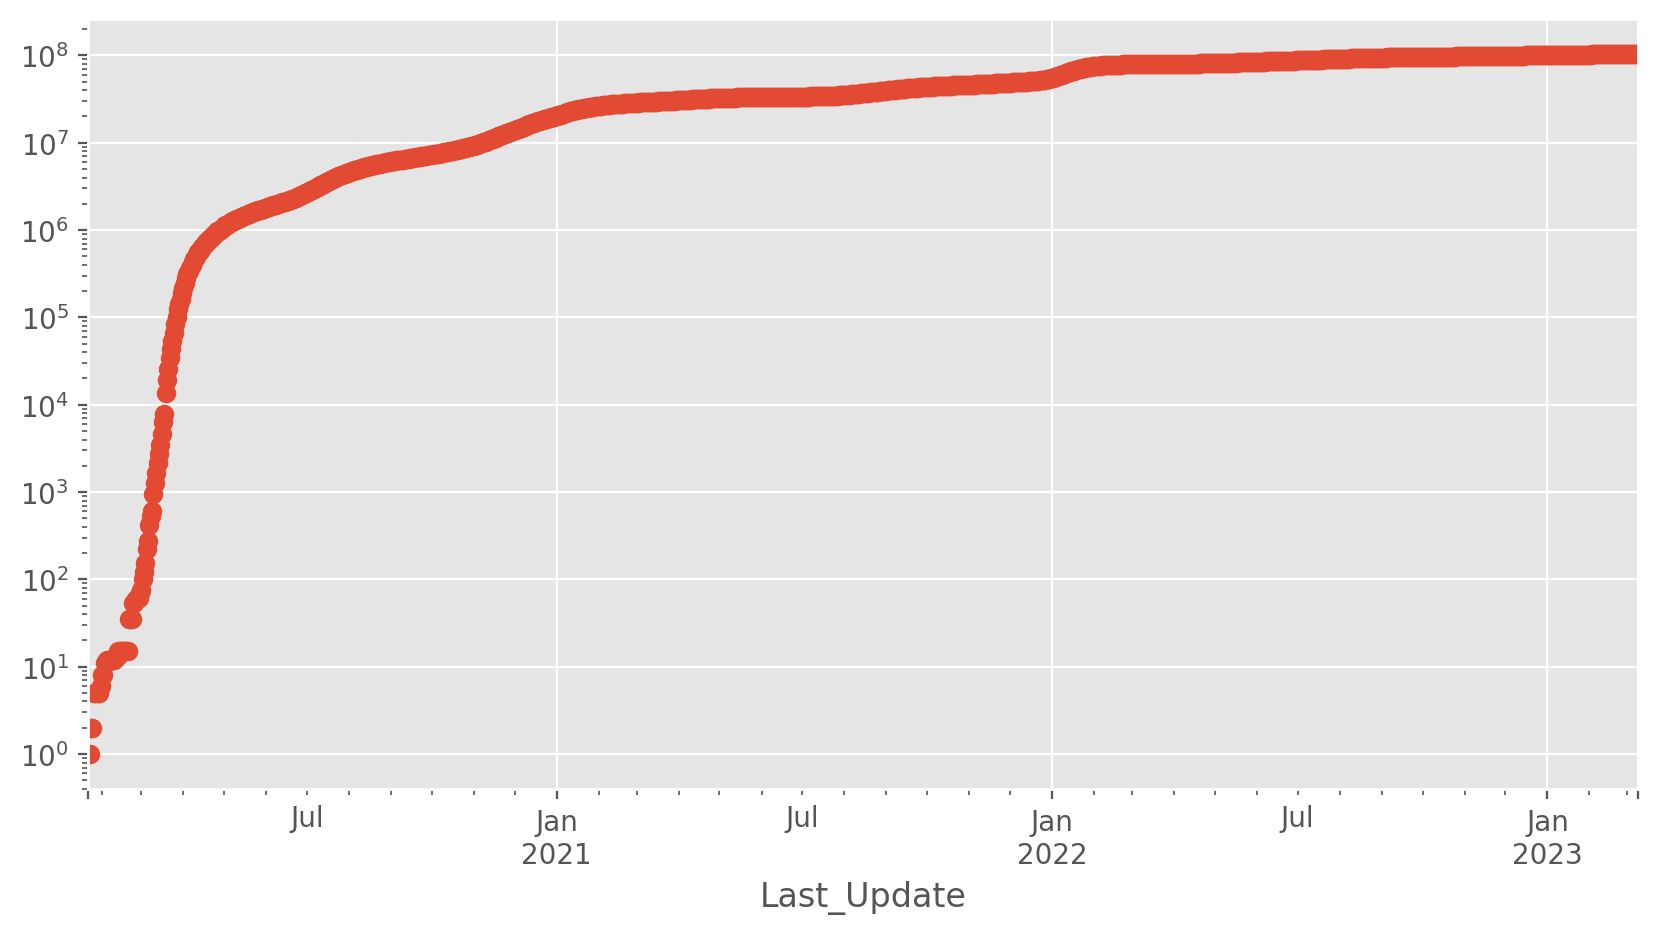

In [10]:
plt.figure(figsize=(10, 5))
all_states.Confirmed.plot(logy=True, style="o");

#### Italy, new cases per day

As another example, let's view the new cases per day for Italy. We will add a rolling mean, just to help guide the eye through the fluctuations - it is not a fit or anything fancy.

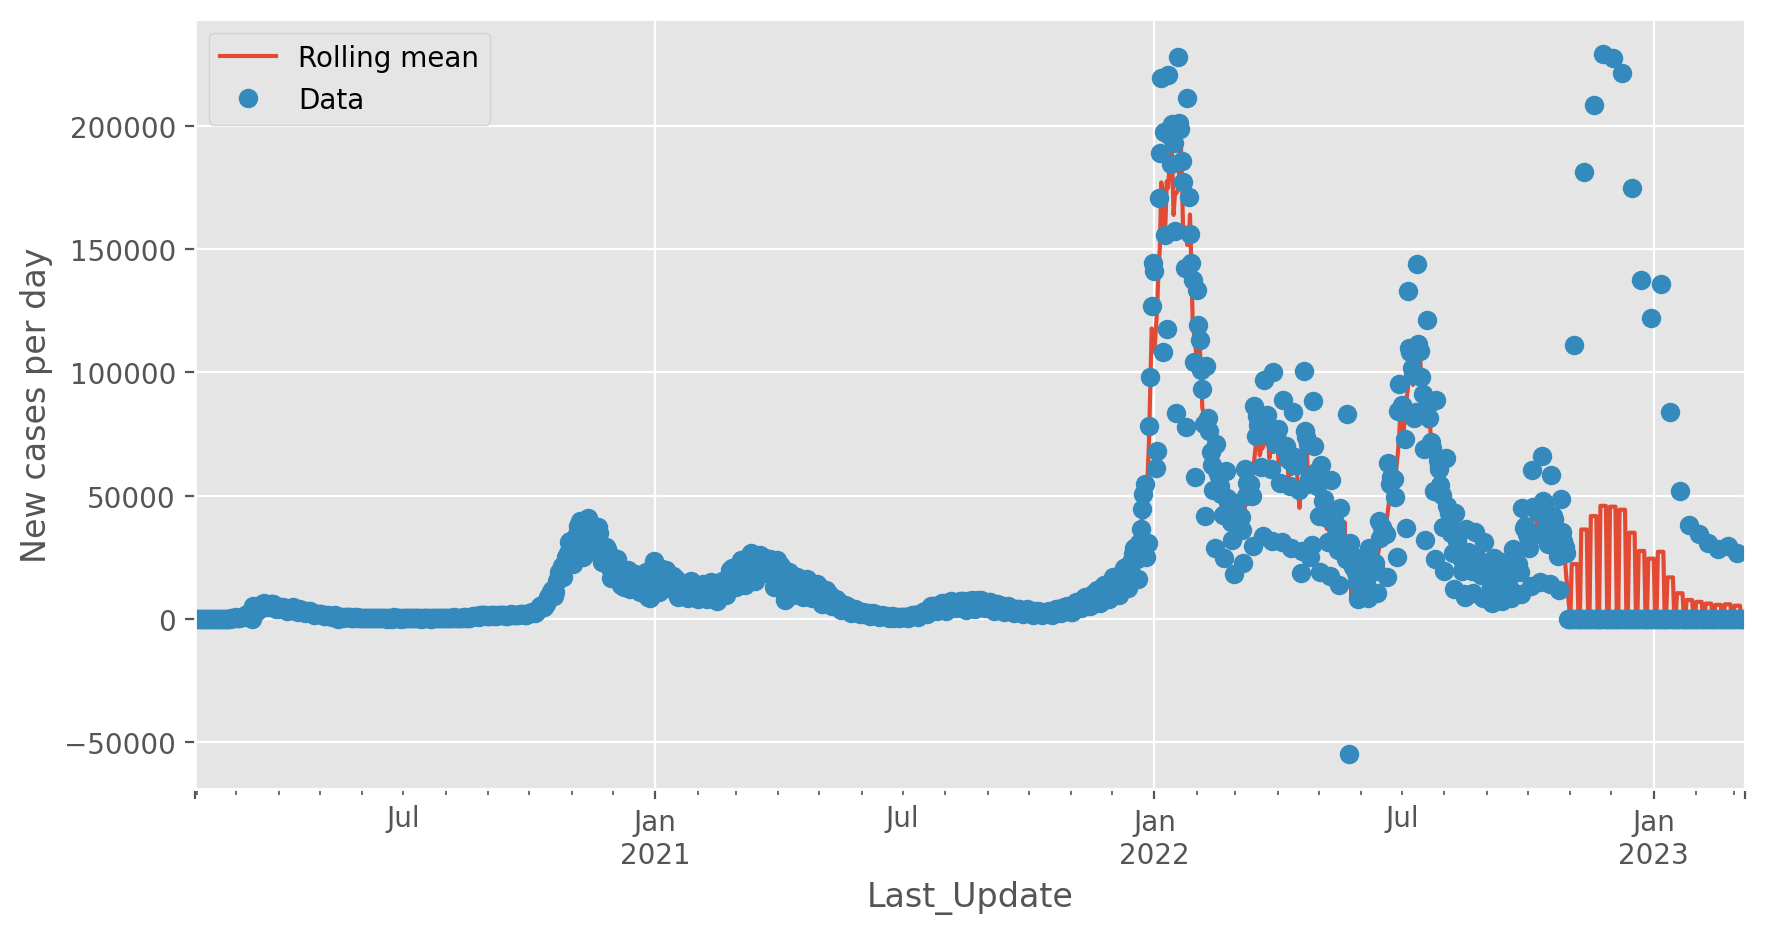

In [11]:
interesting = df.xs("Italy", level="Country_Region").groupby(level="Last_Update").sum()

plt.figure(figsize=(10, 5))
interesting.ΔConfirmed.rolling(5, center=True).mean().plot(
    style="-", label="Rolling mean"
)
interesting.ΔConfirmed.plot(style="o", label="Data")
plt.ylabel("New cases per day")
plt.legend();

#### Italy, transmission rate

It's more interesting to instead look at the transmission rate per day, which is new cases / active cases. The colors in the plot start changing when Italy implemented a lockdown on the 11th, and change over 14 days, which is roughly 1x the time to first symptoms. The lockdown make take longer than that to take full effect. There were several partial steps taken before the full lockdown on the 4th and 9th. Notice the transmission is slowing noticeably!

Text(0, 0.5, 'new cases / active cases')

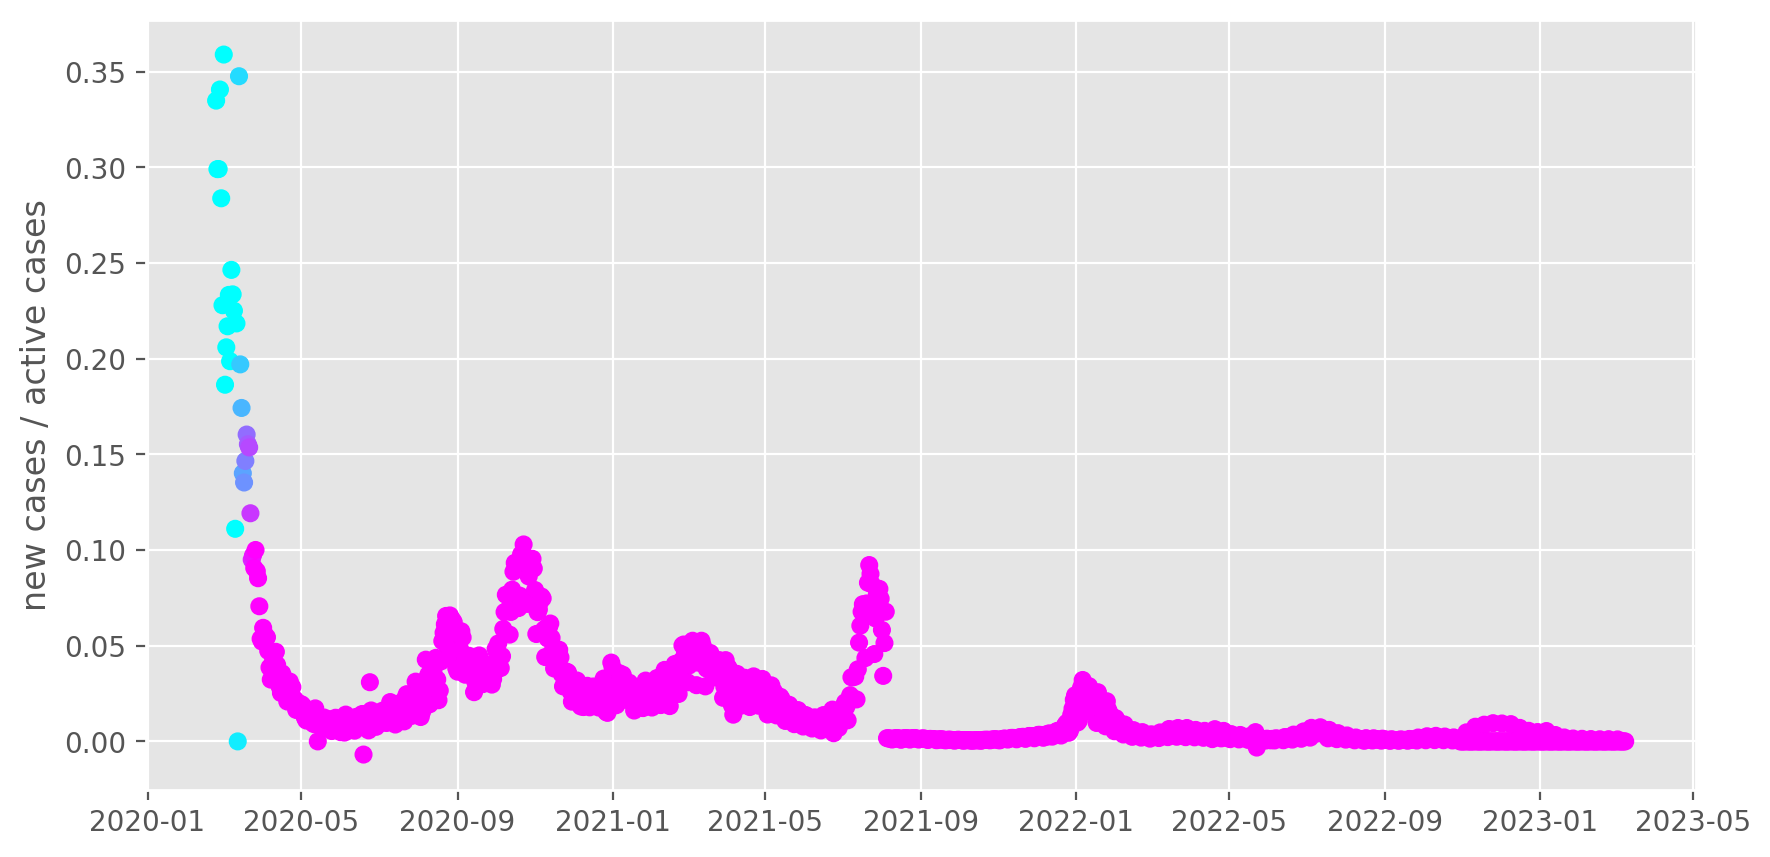

In [12]:
interesting = df.xs("Italy", level="Country_Region").groupby(level="Last_Update").sum()
growth = interesting.ΔConfirmed / interesting.Active
growth = growth["2020-02-24":]

# Color based on lockdown (which happened in 3 stages, 4th, 9th, and 11th)
lockdown = growth.index - pd.Timestamp("2020-03-11")
lockdown = np.clip(lockdown.days, 0, 14) / 14

fix, ax = plt.subplots(figsize=(10, 5))
ax.scatter(growth.index, growth, cmap="cool", c=lockdown)

ax.set_ylabel("new cases / active cases")

#### US, transmission rate

Same plot for the US. The colors in the plot start changing when the US started the 15 plan to slow the spread, and change over 14 days, which is roughly 1x the time to first symptoms. Each state has implemented different guidelines, so the effect will be spread out even futher. Again, we are see the effect of the lockdown!

Text(0, 0.5, 'new cases / active cases')

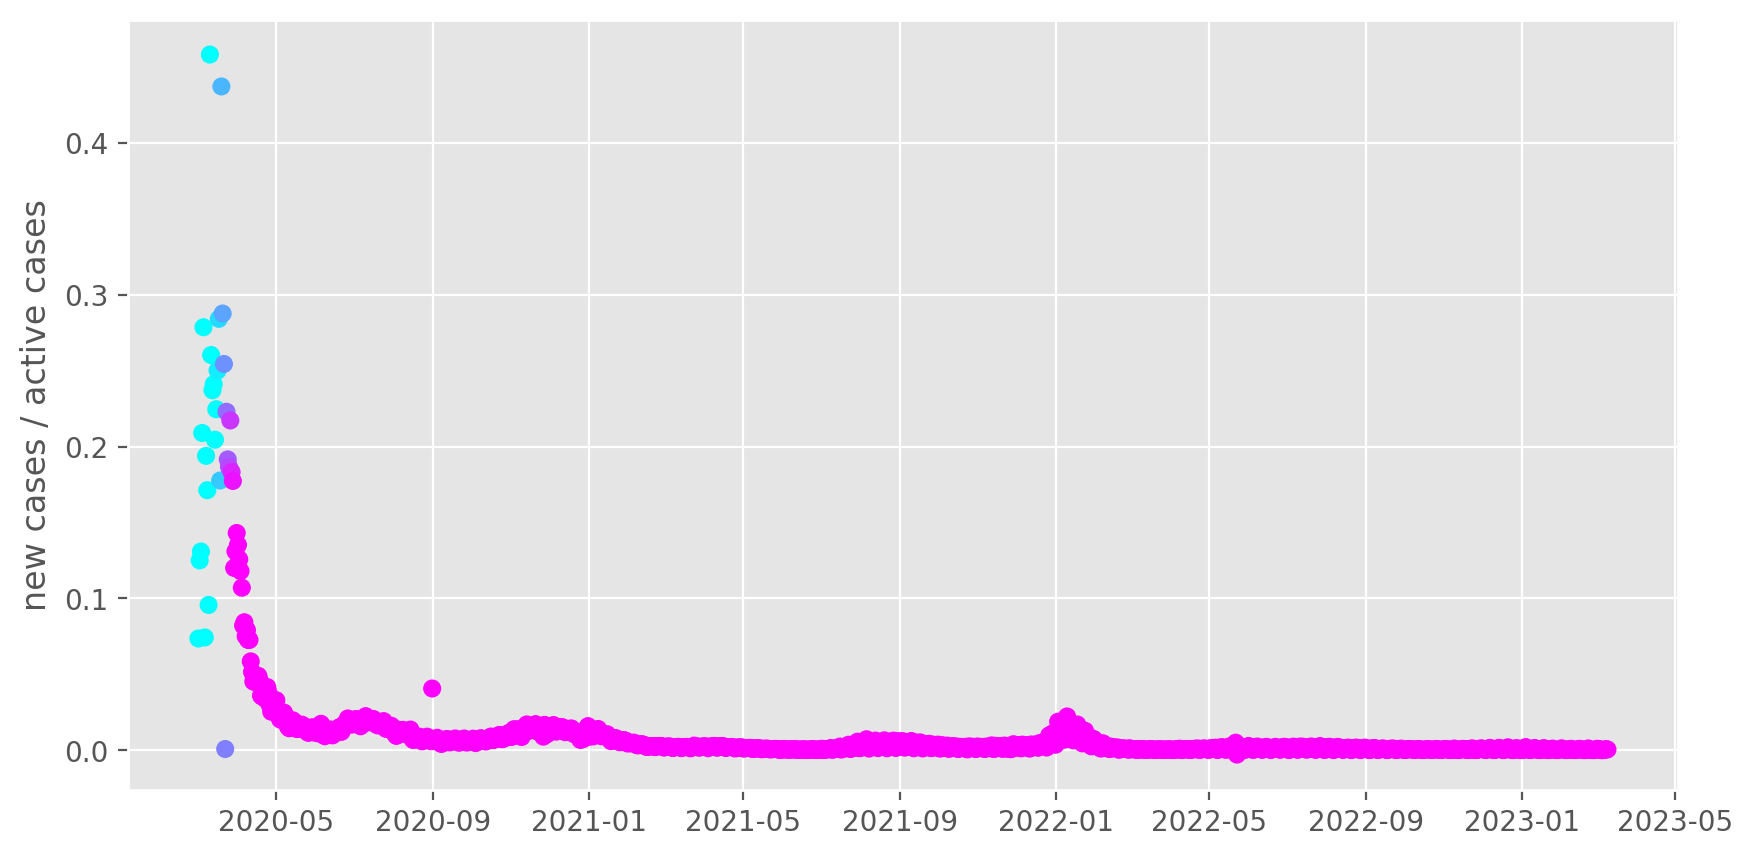

In [13]:
interesting = df.xs("US", level="Country_Region").groupby(level="Last_Update").sum()
growth = interesting.ΔConfirmed / interesting.Active
growth = growth["2020-03-01":]

# Not really a full lockdown, just a distancing guideline + local lockdowns later
lockdown = growth.index - pd.Timestamp("2020-03-15")
lockdown = np.clip(lockdown.days, 0, 14) / 14

fix, ax = plt.subplots(figsize=(10, 5))
ax.scatter(growth.index, growth, cmap="cool", c=lockdown)

ax.set_ylabel("new cases / active cases")